In [1]:
from sklearn.datasets import make_circles

n_samples = 1000
X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42,)


In [2]:
print(f"First 5 X features:\n{X[:5]}")
print(f"\nFirst 5 y labels:\n{y[:5]}")

First 5 X features:
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]

First 5 y labels:
[1 1 1 1 0]


In [3]:
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
                        "X2": X[:, 1],
                        "label": y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


In [4]:
circles.label.value_counts()

1    500
0    500
Name: label, dtype: int64

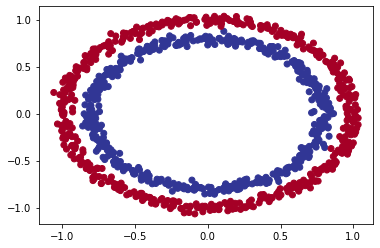

In [5]:
import matplotlib.pyplot as plt

plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu);

In [6]:
X.shape, y.shape

((1000, 2), (1000,))

In [7]:
X_sample = X[0]
y_sample = y[0]

print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


### Turn data into tensors and create train and test splits

In [8]:
import torch

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [9]:
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [10]:
type(X), X.dtype, y.dtype

(torch.Tensor, torch.float32, torch.float32)

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2, # 20% of data will be test
                                                    random_state=42)

In [12]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

### building a model

In [13]:
import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [14]:
class CircleMode1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=5)
        self.layer_2 = nn.Linear(in_features=5, out_features=1)

    def forward(self, x):
        return self.layer_2(self.layer_1(x)) # x-> layer_1 ->layer_2
    
model0 = CircleMode1().to(device)

In [15]:
next(model0.parameters()).device

device(type='cuda', index=0)

In [16]:
model0 = nn.Sequential(
            nn.Linear(in_features=2, out_features=5),
            nn.Linear(in_features=5, out_features=1)
        ).to(device)

model0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [17]:
untrained_preds = model0(X_test.to(device))

In [18]:
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params=model0.parameters(),
                            lr=0.1)

In [19]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [20]:
y_logits = model0(X_test.to(device))[:5]
y_logits

tensor([[-0.1293],
        [ 0.2277],
        [-0.8421],
        [ 0.0717],
        [-0.4879]], device='cuda:0', grad_fn=<SliceBackward0>)

In [21]:
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4677],
        [0.5567],
        [0.3011],
        [0.5179],
        [0.3804]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [22]:
y_preds = torch.round(y_pred_probs)

y_pred_labels = torch.round(torch.sigmoid(model0(X_test.to(device))[:5]))

print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([0., 1., 0., 1., 0.], device='cuda:0', grad_fn=<SqueezeBackward0>)

In [23]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [24]:
torch.manual_seed(42)

epochs = 100

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    model0.train()

    y_logits = model0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits,
                   y_train)

    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred
    )

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    model0.eval()
    with torch.inference_mode():
        test_logits = model0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.72874, Accuracy: 48.38% | Test loss: 0.74603, Test acc: 47.50%
Epoch: 10 | Loss: 0.71218, Accuracy: 49.50% | Test loss: 0.72829, Test acc: 47.50%
Epoch: 20 | Loss: 0.70481, Accuracy: 50.12% | Test loss: 0.71916, Test acc: 47.00%
Epoch: 30 | Loss: 0.70100, Accuracy: 50.38% | Test loss: 0.71362, Test acc: 46.50%
Epoch: 40 | Loss: 0.69874, Accuracy: 50.62% | Test loss: 0.70984, Test acc: 47.00%
Epoch: 50 | Loss: 0.69727, Accuracy: 51.12% | Test loss: 0.70707, Test acc: 47.00%
Epoch: 60 | Loss: 0.69624, Accuracy: 51.00% | Test loss: 0.70494, Test acc: 47.00%


Epoch: 70 | Loss: 0.69550, Accuracy: 51.12% | Test loss: 0.70326, Test acc: 47.50%
Epoch: 80 | Loss: 0.69494, Accuracy: 51.12% | Test loss: 0.70190, Test acc: 48.00%
Epoch: 90 | Loss: 0.69453, Accuracy: 51.25% | Test loss: 0.70080, Test acc: 48.00%


In [25]:
import requests
from pathlib import Path

if Path("helper_function.py").is_file():
    print("helper_functions.py already exists, skipping download")

else:
    print("Downloading helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

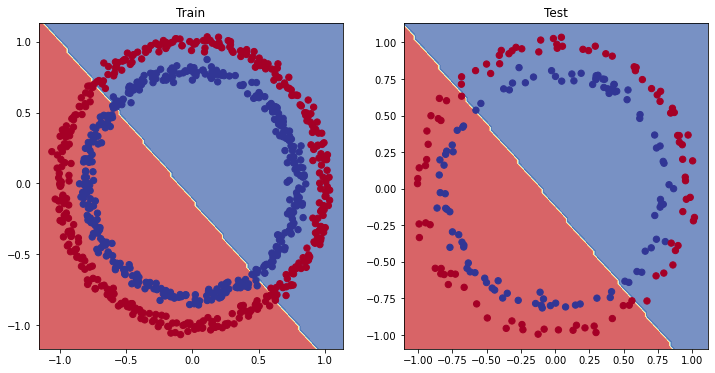

In [26]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model0,X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model0, X_test, y_test)


In [27]:
class CircleMode2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)

    def forward(self, x):
        return self.layer_3(self.layer_2(self.layer_1(x)))
    
model1 = CircleMode2().to(device)
model1

CircleMode2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [28]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model1.parameters(), lr=0.1)

In [29]:
torch.manual_seed(42)

epochs=1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    model1.train()

    y_logits = model1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)
    
    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    model1.eval()
    if epoch % 100 == 0:
        with torch.inference_mode():
            test_logits=model1(X_test).squeeze()
            test_pred=torch.round(torch.sigmoid(test_logits))

            test_loss = loss_fn(test_logits, y_test)
            test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)
            print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69396, Accuracy: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 100 | Loss: 0.69305, Accuracy: 50.38% | Test loss: 0.69379, Test acc: 48.00%
Epoch: 200 | Loss: 0.69299, Accuracy: 51.12% | Test loss: 0.69437, Test acc: 46.00%
Epoch: 300 | Loss: 0.69298, Accuracy: 51.62% | Test loss: 0.69458, Test acc: 45.00%
Epoch: 400 | Loss: 0.69298, Accuracy: 51.12% | Test loss: 0.69465, Test acc: 46.00%
Epoch: 500 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69467, Test acc: 46.00%
Epoch: 600 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 700 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 800 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 900 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%


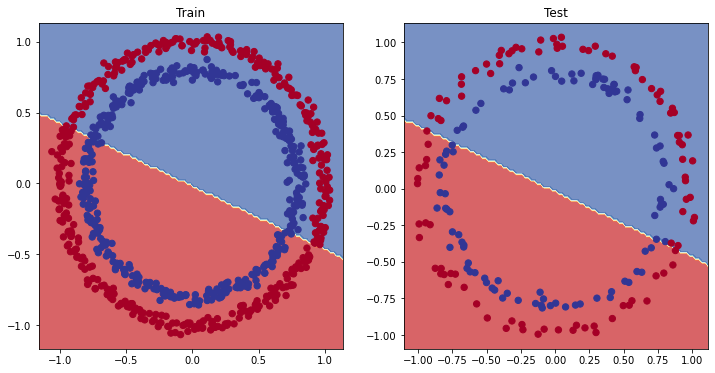

In [30]:
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model1, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model1, X_test, y_test)

In [31]:
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias

print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [32]:
train_split = int(0.8 * len(X_regression))
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

print(len(X_train_regression), 
    len(y_train_regression), 
    len(X_test_regression), 
    len(y_test_regression))

80 80 20 20


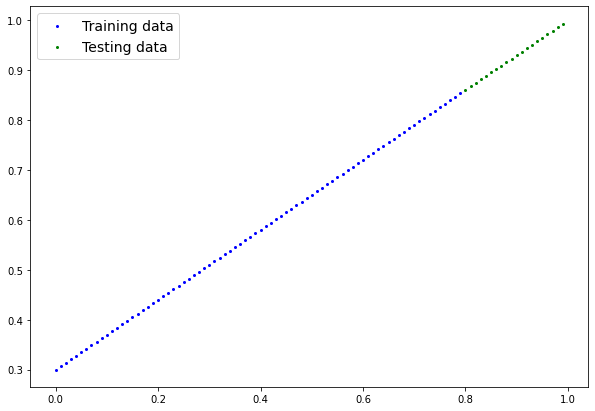

In [33]:
plot_predictions(train_data=X_train_regression,
    train_labels=y_train_regression,
    test_data=X_test_regression,
    test_labels=y_test_regression
);

In [34]:
model2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

model2


Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [35]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(model2.parameters(), lr=0.1)

In [36]:
torch.manual_seed(42)

epochs=1000

X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

for epoch in range(epochs):

    y_pred=model2(X_train_regression)
    loss=loss_fn(y_pred, y_train_regression)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    if epoch % 100 == 0:
        model2.eval()
        y_pred = model2(X_test_regression)
        test_loss = loss_fn(y_pred, y_test_regression)

        print(f"Train loss: {loss:.5f} | Test loss: {test_loss:.5f}")

Train loss: 0.75986 | Test loss: 0.54143
Train loss: 0.09309 | Test loss: 0.02901
Train loss: 0.07376 | Test loss: 0.02850
Train loss: 0.06745 | Test loss: 0.00615
Train loss: 0.06107 | Test loss: 0.02004
Train loss: 0.05698 | Test loss: 0.01061
Train loss: 0.04857 | Test loss: 0.01326
Train loss: 0.06109 | Test loss: 0.02127
Train loss: 0.05599 | Test loss: 0.01426
Train loss: 0.05571 | Test loss: 0.00603


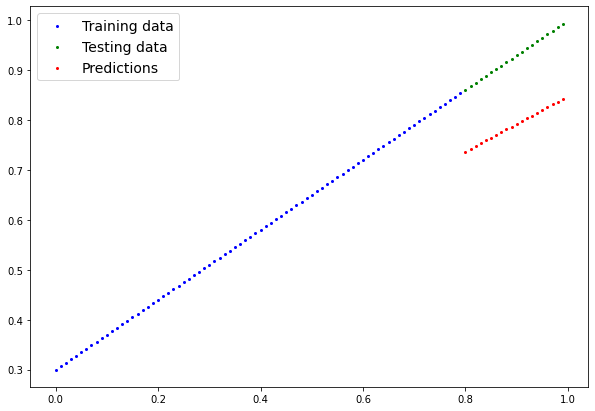

In [37]:
model2.eval()

with torch.inference_mode():
    y_preds = model2(X_test_regression)

plot_predictions(train_data=X_train_regression.cpu(),
                 train_labels=y_train_regression.cpu(),
                 test_data=X_test_regression.cpu(),
                 test_labels=y_test_regression.cpu(),
                 predictions=y_preds.cpu());

## Predicting non-linear data

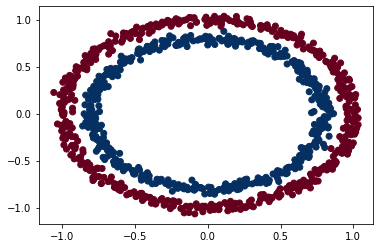

In [38]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples=1000,
                    noise=0.03,
                    random_state=42,)

plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.RdBu);

In [39]:
import torch
from sklearn.model_selection import train_test_split

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2,
                                                    random_state=42
)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

In [40]:
from torch import nn
class Circlemode3(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))
    
model3 = Circlemode3().to(device)
print(model3)

Circlemode3(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


In [41]:
list(model3.parameters())

[Parameter containing:
 tensor([[ 0.5406,  0.5869],
         [-0.1657,  0.6496],
         [-0.1549,  0.1427],
         [-0.3443,  0.4153],
         [ 0.6233, -0.5188],
         [ 0.6146,  0.1323],
         [ 0.5224,  0.0958],
         [ 0.3410, -0.0998],
         [ 0.5451,  0.1045],
         [-0.3301,  0.1802]], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([-0.3258, -0.0829, -0.2872,  0.4691, -0.5582, -0.3260, -0.1997, -0.4252,
          0.0667, -0.6984], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([[ 0.2856, -0.2686,  0.2441,  0.0526, -0.1027,  0.1954,  0.0493,  0.2555,
           0.0346, -0.0997],
         [ 0.0850, -0.0858,  0.1331,  0.2823,  0.1828, -0.1382,  0.1825,  0.0566,
           0.1606, -0.1927],
         [-0.3130, -0.1222, -0.2426,  0.2595,  0.0911,  0.1310,  0.1000, -0.0055,
           0.2475, -0.2247],
         [ 0.0199, -0.2158,  0.0975, -0.1089,  0.0969, -0.0659,  0.2623, -0.1874,
          -0.1886, -0.1886],
         [ 

In [42]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model3.parameters(), lr=0.1)

In [43]:
torch.manual_seed(42)
epochs= 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    y_logits = model3(X_train).squeeze()
    pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true = y_train, y_pred = pred)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()
    model3.eval()
    if epoch % 100 == 0:
        
        with torch.inference_mode():
            test_y_logits = model3(X_test).squeeze()
            test_pred = torch.round(torch.sigmoid(test_y_logits))

            test_loss = loss_fn(test_y_logits, y_test)
            test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)
        print(epoch, loss, acc, test_loss, test_acc)



0 tensor(0.6929, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) 50.0 tensor(0.6932, device='cuda:0') 50.0


100 tensor(0.6912, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) 52.87500000000001 tensor(0.6910, device='cuda:0') 52.5
200 tensor(0.6898, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) 53.37499999999999 tensor(0.6894, device='cuda:0') 55.00000000000001
300 tensor(0.6879, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) 53.0 tensor(0.6872, device='cuda:0') 56.00000000000001
400 tensor(0.6852, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) 52.75 tensor(0.6841, device='cuda:0') 56.49999999999999
500 tensor(0.6810, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) 52.75 tensor(0.6794, device='cuda:0') 56.49999999999999
600 tensor(0.6751, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) 54.50000000000001 tensor(0.6729, device='cuda:0') 56.00000000000001
700 tensor(0.6666, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>

In [44]:
model3.eval()
with torch.inference_mode():
    pred = torch.round(torch.sigmoid(model3(X_test))).squeeze()
pred[:10], y[:10]

(tensor([1., 0., 1., 0., 0., 1., 0., 0., 1., 0.], device='cuda:0'),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.]))

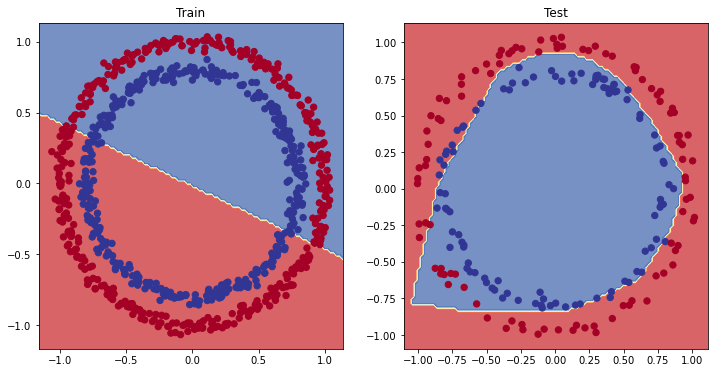

In [45]:
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model1, X_train, y_train) # model_1 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model3, X_test, y_test)

In [46]:
from sklearn.datasets import make_blobs

[[-8.41339595  6.93516545]
 [-5.76648413 -6.43117072]
 [-6.04213682 -6.76610151]
 [ 3.95083749  0.69840313]
 [ 4.25049181 -0.28154475]] tensor([3, 2, 2, 1, 1])


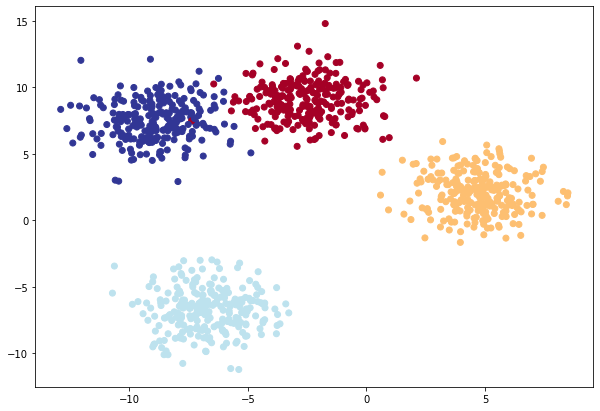

In [47]:
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

X_blob, y_blob = make_blobs(n_samples = 1000,
                            n_features = NUM_FEATURES,
                            centers = NUM_CLASSES,
                            cluster_std = 1.5,
                            random_state=RANDOM_SEED,
)

x_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
    y_blob,
    test_size=0.2,
    random_state=RANDOM_SEED
)

plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

In [48]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [49]:
from torch import nn

class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features = input_features, out_features = hidden_units),
            nn.Linear(in_features = hidden_units, out_features = hidden_units),
            nn.Linear(in_features = hidden_units, out_features = output_features)
        )
    
    def forward(self, x):
        return self.linear_layer_stack(x)
    
model4 = BlobModel(input_features=NUM_FEATURES,
                   output_features = NUM_CLASSES,
                   hidden_units=8).to(device)
model4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [50]:
model4 = model4.to(device)

In [51]:
next(model4.parameters()).device

device(type='cuda', index=0)

In [52]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model4.parameters(),
                            lr=0.1)

In [53]:
model4(torch.from_numpy(X_blob_train).type(torch.float).to(device))

tensor([[-1.2711, -0.6494, -1.4740, -0.7044],
        [ 0.2210, -1.5439,  0.0420,  1.1531],
        [ 2.8698,  0.9143,  3.3169,  1.4027],
        ...,
        [-0.0148, -1.5722, -0.2221,  0.9874],
        [ 2.3231,  0.6656,  2.6783,  1.1564],
        [ 2.1249, -0.9140,  2.2318,  2.1890]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [54]:
model4(torch.from_numpy(X_blob_train).type(torch.float).to(device))[0].shape, NUM_CLASSES

(torch.Size([4]), 4)

In [55]:
X_blob_train = torch.from_numpy(X_blob_train).type(torch.float).to(device)
X_blob_test = torch.from_numpy(X_blob_test).type(torch.float).to(device)

In [56]:
y_blob_train = y_blob_train.to(device)
y_blob_test = y_blob_test.to(device)

In [57]:
torch.manual_seed(42)

epochs=100

for epoch in range(epochs):
    model4. train()

    y_logits = model4(X_blob_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(y_true = y_blob_train,
                      y_pred = y_pred)
    
    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    if epoch % 10 == 0:
        model4.eval()
        y_logits = model4(X_blob_test)
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

        test_loss = loss_fn(y_logits, y_blob_test)
        test_accuracy= accuracy_fn(y_true = y_blob_test,
                    y_pred = y_pred)
        
        print(f"loss: {loss}, acc: {acc}, test_loss: {test_loss}, test_acc: {test_accuracy}")


loss: 1.0432369709014893, acc: 65.5, test_loss: 0.5786146521568298, test_acc: 95.5
loss: 0.14397816359996796, acc: 99.125, test_loss: 0.13037429749965668, test_acc: 99.0
loss: 0.08061711490154266, acc: 99.125, test_loss: 0.07216107845306396, test_acc: 99.5
loss: 0.05923594906926155, acc: 99.125, test_loss: 0.05133283510804176, test_acc: 99.5
loss: 0.0489191897213459, acc: 99.0, test_loss: 0.04098135977983475, test_acc: 99.5
loss: 0.04294963181018829, acc: 99.0, test_loss: 0.03486067056655884, test_acc: 99.5
loss: 0.03909869119524956, acc: 99.0, test_loss: 0.03083428554236889, test_acc: 99.5
loss: 0.03642876073718071, acc: 99.0, test_loss: 0.027988385409116745, test_acc: 99.5
loss: 0.03448032960295677, acc: 99.0, test_loss: 0.025870518758893013, test_acc: 99.5


loss: 0.03300289064645767, acc: 99.125, test_loss: 0.0242322850972414, test_acc: 99.5


In [58]:
model4.eval()
with torch.inference_mode():
    y_logits = model4(X_blob_test)

y_logits[:10]

tensor([[  4.3377,  10.3539, -14.8948,  -9.7642],
        [  5.0142, -12.0371,   3.3860,  10.6699],
        [ -5.5885, -13.3448,  20.9894,  12.7711],
        [  1.8400,   7.5599,  -8.6016,  -6.9942],
        [  8.0726,   3.2906, -14.5998,  -3.6186],
        [  5.5844, -14.9521,   5.0168,  13.2890],
        [ -5.9739, -10.1913,  18.8655,   9.9179],
        [  7.0755,  -0.7601,  -9.5531,   0.1736],
        [ -5.5918, -18.5990,  25.5309,  17.5799],
        [  7.3142,   0.7197, -11.2017,  -1.2011]], device='cuda:0')

In [60]:
y_pred_probs = torch.softmax(y_logits, dim=1)

y_pred = y_pred_probs.argmax(dim=1)

print(f"Predictions: {y_pred[:10]}\nLabels: {y_blob_test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_true=y_blob_test, y_pred=y_pred)}%")

Predictions: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Labels: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Test accuracy: 99.5%


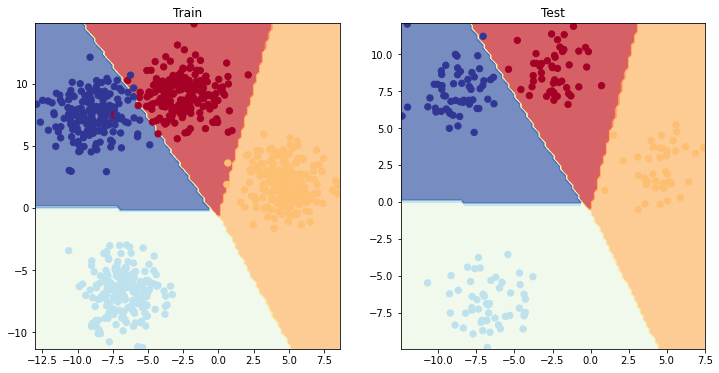

In [79]:
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title("Train")

plot_decision_boundary(model4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model4, X_blob_test, y_blob_test)